In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt

# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

# 导入模型
from src.Bayesian_state import *
from src.Bayesian_state.problems import *

INFO:cat-learning:logger is running normally.


/home/yangjiong/CategoryLearning_gitcode/logs/Run_20251224_215338.log
{'default_model': {'modules': {}, 'agenda': ['__self__']}, 'm_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 15.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.8, 'gamma': 0.8}}}, 'agenda': ['likelihood_mod', 'memory_mod']}, 'base_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {}}}, 'agenda': ['likelihood_mod', '__self__']}, 'p_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {}}, 'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}}, 'agenda': ['perception_mod', 'likelihood_mod', '__self__']}, 'pmh_model': {'modules': {'perception_mod': {'class': 'src.Bayesian_state.problem

In [31]:
h = Partition(4,4)

In [32]:
splits = h.get_all_splits()

In [15]:
data_sub1 = learning_data[learning_data['iSub'] == 1].copy()

trial_columns = ['iTrial', 'feature1', 'feature2', 'feature3', 'feature4', 'feature1_oral', 'feature2_oral', 'feature3_oral', 'feature4_oral', 'category', 'choice']
trial_data = data_sub1[trial_columns]

In [27]:
splits_file_path = Path(project_root) / 'data' / 'processed' / 'splits.csv'
splits_data = pd.read_csv(splits_file_path)

In [23]:
# Convert the 'category' column to the new format where 1,2 become 1, and 3,4 become 2
data_sub1['category'] = data_sub1['category'].apply(lambda x: 1 if x in [1, 2] else 2)

# Initialize belief_1 and belief_2 columns
data_sub1['belief_1'] = None
data_sub1['belief_2'] = None

# Loop over the trials to update belief_1 and belief_2
for i in range(1, len(data_sub1)):
    current_choice = data_sub1.at[i, 'choice']
    
    if current_choice == 1:
        data_sub1.at[i, 'belief_1'] = [data_sub1.at[i, 'feature1_oral'], 
                                       data_sub1.at[i, 'feature2_oral'], 
                                       data_sub1.at[i, 'feature3_oral'], 
                                       data_sub1.at[i, 'feature4_oral']]
        data_sub1.at[i, 'belief_2'] = data_sub1.at[i - 1, 'belief_2']
    elif current_choice == 2:
        data_sub1.at[i, 'belief_2'] = [data_sub1.at[i, 'feature1_oral'], 
                                       data_sub1.at[i, 'feature2_oral'], 
                                       data_sub1.at[i, 'feature3_oral'], 
                                       data_sub1.at[i, 'feature4_oral']]
        data_sub1.at[i, 'belief_1'] = data_sub1.at[i - 1, 'belief_1']

# Check the first few rows to verify the new belief columns
data_sub1[['belief_1', 'belief_2']].head()


,belief_1,belief_2
0,None,None
1,"[0.25, 0.75, 0.25, 0.5]",None
2,"[0.25, 0.5, 0.25, 0.25]",None
3,"[0.25, 0.5, 0.25, 0.25]","[0.75, 0.25, 0.75, 0.75]"
4,"[0.25, 0.5, 0.25, 0.25]","[0.75, 0.75, 0.75, 0.25]"


In [28]:
# Function to check if belief matches any of the 19 predefined splits
def check_match(belief_1, belief_2, splits):
    match_found = False
    for _, row in splits.iterrows():
        # Compare belief_1 and belief_2 with the centers of the split
        center_c1 = row['center_c1']
        center_c2 = row['center_c2']
        
        # Compute the distance between belief_1 and center_c1, and belief_2 and center_c2
        if (belief_1 == center_c1 and belief_2 == center_c2):
            match_found = True
            break
    
    return match_found

# Create a new column to store if the belief matches any of the predefined splits
data_sub1['match'] = data_sub1.apply(lambda row: check_match(row['belief_1'], row['belief_2'], splits_data), axis=1)

# Show the first few rows with the match results
data_sub1[['belief_1', 'belief_2', 'match']].head()


,belief_1,belief_2,match
0,None,None,False
1,"[0.25, 0.75, 0.25, 0.5]",None,False
2,"[0.25, 0.5, 0.25, 0.25]",None,False
3,"[0.25, 0.5, 0.25, 0.25]","[0.75, 0.25, 0.75, 0.75]",False
4,"[0.25, 0.5, 0.25, 0.25]","[0.75, 0.75, 0.75, 0.25]",False


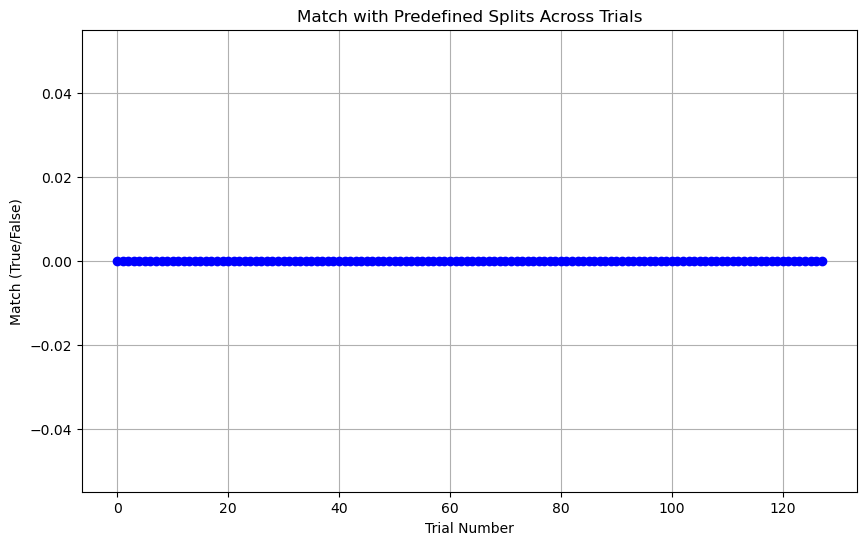

In [29]:
import matplotlib.pyplot as plt

# Plot the match vs. trial number to see how the match evolves across trials
plt.figure(figsize=(10, 6))
plt.plot(data_sub1.index, data_sub1['match'], marker='o', linestyle='-', color='b')
plt.title('Match with Predefined Splits Across Trials')
plt.xlabel('Trial Number')
plt.ylabel('Match (True/False)')
plt.grid(True)
plt.show()


In [13]:
splits_file_path = Path(project_root) / 'data' / 'processed' / 'splits.csv'
splits_data = pd.read_csv(splits_file_path)

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Create a directory to save the plots if it doesn't exist
output_dir = Path(project_root) / 'results' / 'oral_plots'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Define a function to plot the 3D scatter plot and hyperplane
def plot_trial_3d(trial_data, match_proportion, hyperplane, trial_num):
    """
    Plot a 3D scatter plot with the trial data and the hyperplane if match_proportion > 0.5.
    trial_data: DataFrame with the trial data containing feature1, feature2, feature3, and category.
    match_proportion: the proportion of matches for the current trial window.
    hyperplane: the hyperplane equation to plot (if applicable).
    trial_num: the trial number to save the plot as an image file.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the 3D scatter points for each trial's features
    blue_points = trial_data[trial_data['category'] == 1]
    red_points = trial_data[trial_data['category'] == 2]
    
    ax.scatter(blue_points['feature1'], blue_points['feature2'], blue_points['feature3'], color='blue', label='Category 1')
    ax.scatter(red_points['feature1'], red_points['feature2'], red_points['feature3'], color='red', label='Category 2')
    
    # If the match proportion is greater than 0.5, plot the hyperplane
    if match_proportion > 0 and hyperplane is not None:
        # Extract the hyperplane equation (assuming it's simple, e.g., x1 = 0.5 or x1 - x2 = 0)
        if '=' in hyperplane:
            feature, value = hyperplane.split('=')
            value = float(value.strip())
            if feature == 'x1':
                x1_vals = np.linspace(min(trial_data['feature1']), max(trial_data['feature1']), 100)
                x2_vals = np.full_like(x1_vals, value)
                x3_vals = np.full_like(x1_vals, np.mean(trial_data['feature3']))
                ax.plot(x1_vals, x2_vals, x3_vals, color='green', label='Hyperplane: x1 = 0.5')

    ax.set_xlabel('Feature 2')
    ax.set_ylabel('Feature 1')
    ax.set_zlabel('Feature 3')
    ax.set_title(f"Trial {trial_num}")
    ax.legend()

    # Save the plot as an image
    plt.savefig(f"{output_dir}/trial_{trial_num}.png")
    plt.close()

# Loop through the trials starting from the 8th and generate the plots
for trial_num in range(7, num_trials):  # Starting from the 8th trial (index 7)
    # Select the trials from the 1st to the current trial
    trial_window_data = trial_data.iloc[:trial_num + 1]

    # Calculate the match_proportion for the current window
    match_proportion = match_proportions[trial_num - 7]  # Subtract 7 to align with the match_proportions list

    # Retrieve the best matching hyperplane (for simplicity, assuming the first match)
    if match_proportion > 0.5:
        # Get the best matching hyperplane from the split data
        # For now, using the first valid hyperplane from splits_data for simplicity
        best_hyperplane = splits_data['hyperplane'].iloc[0]
    else:
        best_hyperplane = None

    # Plot and save the 3D scatter plot for the current trial
    plot_trial_3d(trial_window_data, match_proportion, best_hyperplane, trial_num + 1)


